# This will be the WeatherPy sub-challenge

In [1]:
from api_keys import api_key
import requests
import random as r
import numpy as np
import pandas as pd
from time import sleep
from datetime import date as dt
from citipy import citipy as cp
from matplotlib import pyplot as plt
from scipy import stats as st

In [2]:
# Create a fcunction to produce latitudes in realistic areas
def smart_lat():
    return 110/np.pi*np.arcsin((2*r.random()-1))

In [3]:
# Create a function that gets the closest city to a coordinate point
def get_city(lat='random', lon='random'):
    
    # If lat is not given use random latitude
    if lat == 'random':
        lat = 180*(r.random()-.5)
    if lat == 'smart':
        lat = smart_lat()

    # If lon is not given use random longitude
    if lon == 'random':
        lon = 360*(r.random()-.5)

    # Get nearest city to coordinates
    city = cp.nearest_city(lat, lon)
    
    # Return the name of the city
    return f'{city.city_name.capitalize()}, {city.country_code.upper()}'

In [4]:
# Create a function to check if sample city is arealdy in list
def is_duplicate(item, items):
        
    # Check if the sample city is in list...
    if item in items:
                
        # retrun true
        return True
    
    # Otherwise...
    else:
    
        # return false
        return False

In [5]:
# Create a function to get a city coords
def get_city_info(query):
    
    # Geocoder base api access point
    geo_query_url = f'http://api.openweathermap.org/geo/1.0/direct?appid={api_key}&q='
    
    # Call geocoder api
    response = requests.get(f'{geo_query_url}{query}').json()[0]
    
    # Return name, lat and lon as dictionary
    return {'name': f"{response['name']}, {response['country']}",
            'lat': response['lat'],
            'lon': response['lon']}

In [6]:
# Create a function to get weather at a city (with lon/lat for city)
def get_city_weather(city_info, units='imperial'):
    
    # Get lon and lat from city info
    lat = city_info['lat']
    lon = city_info['lon']
    
    # Base url to get weatehr by lon/lat
    weather_url = f'https://api.openweathermap.org/data/2.5/weather?units={units}&appid={api_key}&'
    
    # Call open weather api
    response = requests.get(f'{weather_url}lat={lat}&lon={lon}').json()
    
    return {'temp': response['main']['temp'],
            'humidity': response['main']['humidity'],
            'clouds': response['clouds']['all'],
            'wind_speed':response['wind']['speed']}

In [7]:
# Create a function to gather city and weather info and package as a dataframe
def  get_weather_vs_lat(num_of_rows):
    
    # Get today's date
    today = dt.today()
    print(f"Looking for weather info for {num_of_rows} cities. Today's date is {today}.\n-------------------------------------------------------------------------------------")
    
    # Intitailize initial value(s) and lists
    success_count = 0
    attempt_count = 0
    cities = []
    city_names = []
    lats = []
    lons = []
    temps = []
    humidities = []
    clouds_list = []
    wind_speeds = []

    # Loop until limit is reached
    while success_count < num_of_rows:
        
        # Increment attempt counter
        attempt_count += 1
        
        # Get city closest to a random point on globe where lat is between -60 and +60 and lon is uniform random between -180 and +180
        city = get_city(lat='smart')
        
        print(f'Attempt number {attempt_count} for city number {success_count + 1}.')
        print(f'Selecting nearest city to random coordinates... Success: City is {city}.')
        
        # If random city is duplicate, go back to start of loop and try again
        if is_duplicate(city, cities): 
            print(f'Checking if selected city is unique... Failed: {city} is already on list!')
            continue
        else:
            
            print(f'Checking if selected city is unique... Success: {city} is not on list already.')
            # If city is unique, add it to the list of cities queried so it does not appear again
            cities.append(city)
            
            # Try to get the city info (cleaned up name, latitude, longitude)
            try:
                city_info = get_city_info(city)
                
                # Wait for 1 sec to help with 
                sleep(1)
                
                print(f"Getting city information... Success: Found {city} at {city_info['lat']}, {city_info['lon']}.")
            
            # If city info is not available for the target city, got back to the start of the loop and try again
            except IndexError as error: 
                print(f'Getting city information... Failed: Cannot find coordinates for {city}!')
                continue
            
            # As long as city info is obtained successfully, get the weather for the city
            city_weather = get_city_weather(city_info)
            print(f'Getting weather information... Success: Added weather info for {city}.\n-------------------------------------------------------------------------------------')
            
            # Wait 1 sec to adhere to api rate limiting
            sleep(1)

            # Add current info to list
            city_names.append(city_info['name'])
            lats.append(city_info['lat'])
            lons.append(city_info['lon'])
            temps.append(city_weather['temp'])
            humidities.append(city_weather['humidity'])
            clouds_list.append(city_weather['clouds'])
            wind_speeds.append(city_weather['wind_speed'])

            # Increment because a city's info and weather was successfully added and reset attempts
            success_count += 1
            attempt_count = 0

    # Create df from lists
    degrees = '\u00B0'
    return pd.DataFrame({'city': city_names,
                         f'latitude ({degrees}N)': lats,
                         f'longitude ({degrees}E)': lons,
                         f'temperature ({degrees}F)': temps,
                         'humidity (%)': humidities, 
                         'cloudiness (%)': clouds_list,
                         'wind speed (mph)': wind_speeds})

In [8]:
# Create a function to print a scatter plot
def scatter(dataframe, col1, col2, regress=False, subset='all', units='imperial', save=False):
    plot_type = 'Scatter plot'
    today = dt.today()
    if subset == 'all':
        dataframe_sub = dataframe
    if subset == 'positive':
        dataframe_sub = dataframe.loc[dataframe[col1] >= 0, :]
    if subset == 'negative':
        dataframe_sub = dataframe.loc[dataframe[col1] < 0, :]
    x = dataframe_sub[col1]
    y = dataframe_sub[col2]
    plt.scatter(x, y, alpha=.5)
    x_mar = 1/20*(max(x) - min(x))
    y_mar = 1/10*(max(y) - min(y))
    plt.xlim(min(x) - x_mar,max(x) + x_mar)
    plt.ylim(min(y) - y_mar,max(y) + y_mar)
    plt.xlabel(col1)
    plt.ylabel(col2)
    if regress == True:
        m, b, r, p, e = st.linregress(x, y)
        x_lin = [-90, 90]
        y_hat = [m*x+b for x in x_lin]
        y_hat_sym = "\u0177"
        y_hat_eq = f'{y_hat_sym}={round(m, 2)}*x+{round(b, 2)}, p={"{:.2e}".format(p)}, r={round(r, 2)}'
        x_a = min(x) + x_mar
        y_a = max(y) - y_mar
        plt.plot(x_lin, y_hat, c='red')
        plt.annotate(y_hat_eq, (x_a, y_a), c='red')
        plot_type = 'Regression'
    plt.title(f'{plot_type} of {col2} vs {col1}\n for {subset} {col1}s on {today}')
    if save:
        fname = f'Output/{col2}_vs_{col1}_subset_{subset}_regress_{regress}'
        plt.savefig(fname)
    plt.show()

In [9]:
weather_data = get_weather_vs_lat(500)

Looking for weather info for 500 cities. Today's date is 2022-08-14.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 1.
Selecting nearest city to random coordinates... Success: City is Tandur, IN.
Checking if selected city is unique... Success: Tandur, IN is not on list already.
Getting city information... Success: Found Tandur, IN at 19.1519551, 79.4488599.
Getting weather information... Success: Added weather info for Tandur, IN.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 2.
Selecting nearest city to random coordinates... Success: City is Kapaa, US.
Checking if selected city is unique... Success: Kapaa, US is not on list already.
Getting city information... Success: Found Kapaa, US at 22.0747334, -159.3191601.
Getting weather information... Success: Added weather info for Kapaa, US.
---------------------------------------------------------

Getting city information... Success: Found Port-gentil, GA at -0.7149116, 8.7797434.
Getting weather information... Success: Added weather info for Port-gentil, GA.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 18.
Selecting nearest city to random coordinates... Success: City is Adrar, DZ.
Checking if selected city is unique... Success: Adrar, DZ is not on list already.
Getting city information... Success: Found Adrar, DZ at 27.8733807, -0.2874884.
Getting weather information... Success: Added weather info for Adrar, DZ.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 19.
Selecting nearest city to random coordinates... Success: City is Souillac, MU.
Checking if selected city is unique... Success: Souillac, MU is not on list already.
Getting city information... Success: Found Souillac, MU at -20.5187236, 57.522503.
Getting weather information...

Getting city information... Success: Found Touros, BR at -5.1998625, -35.4595051.
Getting weather information... Success: Added weather info for Touros, BR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 36.
Selecting nearest city to random coordinates... Success: City is Atuona, PF.
Checking if selected city is unique... Failed: Atuona, PF is already on list!
Attempt number 2 for city number 36.
Selecting nearest city to random coordinates... Success: City is Kapaa, US.
Checking if selected city is unique... Failed: Kapaa, US is already on list!
Attempt number 3 for city number 36.
Selecting nearest city to random coordinates... Success: City is Platanos, GR.
Checking if selected city is unique... Success: Platanos, GR is not on list already.
Getting city information... Success: Found Platanos, GR at 35.469581, 23.6007937.
Getting weather information... Success: Added weather info for Platanos, GR.
---------------

Getting city information... Success: Found Faya, TD at 8.0748388, 16.0806637.
Getting weather information... Success: Added weather info for Faya, TD.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 50.
Selecting nearest city to random coordinates... Success: City is Palabuhanratu, ID.
Checking if selected city is unique... Success: Palabuhanratu, ID is not on list already.
Getting city information... Success: Found Palabuhanratu, ID at -6.9882409, 106.5503728.
Getting weather information... Success: Added weather info for Palabuhanratu, ID.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 51.
Selecting nearest city to random coordinates... Success: City is Vrangel, RU.
Checking if selected city is unique... Success: Vrangel, RU is not on list already.
Getting city information... Success: Found Vrangel, RU at 71.224739, -178.71703505.
Getting weat

Attempt number 1 for city number 64.
Selecting nearest city to random coordinates... Success: City is Butaritari, KI.
Checking if selected city is unique... Success: Butaritari, KI is not on list already.
Getting city information... Success: Found Butaritari, KI at 2.9205375, 172.91886331442205.
Getting weather information... Success: Added weather info for Butaritari, KI.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 65.
Selecting nearest city to random coordinates... Success: City is Ixtapa, MX.
Checking if selected city is unique... Success: Ixtapa, MX is not on list already.
Getting city information... Success: Found Ixtapa, MX at 16.8032586, -92.9053697.
Getting weather information... Success: Added weather info for Ixtapa, MX.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 66.
Selecting nearest city to random coordinates... Success: City

Getting city information... Failed: Cannot find coordinates for Dicabisagan, PH!
Attempt number 2 for city number 79.
Selecting nearest city to random coordinates... Success: City is Hilo, US.
Checking if selected city is unique... Failed: Hilo, US is already on list!
Attempt number 3 for city number 79.
Selecting nearest city to random coordinates... Success: City is Kapaa, US.
Checking if selected city is unique... Failed: Kapaa, US is already on list!
Attempt number 4 for city number 79.
Selecting nearest city to random coordinates... Success: City is Matara, LK.
Checking if selected city is unique... Success: Matara, LK is not on list already.
Getting city information... Success: Found Matara, LK at 5.947822, 80.5482919.
Getting weather information... Success: Added weather info for Matara, LK.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 80.
Selecting nearest city to random coordinates... Success: City is Na

Getting city information... Success: Found Ribeira grande, PT at 37.8225227, -25.5194914.
Getting weather information... Success: Added weather info for Ribeira grande, PT.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 95.
Selecting nearest city to random coordinates... Success: City is Rikitea, PF.
Checking if selected city is unique... Failed: Rikitea, PF is already on list!
Attempt number 2 for city number 95.
Selecting nearest city to random coordinates... Success: City is Puerto ayora, EC.
Checking if selected city is unique... Failed: Puerto ayora, EC is already on list!
Attempt number 3 for city number 95.
Selecting nearest city to random coordinates... Success: City is Kathu, TH.
Checking if selected city is unique... Success: Kathu, TH is not on list already.
Getting city information... Success: Found Kathu, TH at 7.9093905, 98.3336498.
Getting weather information... Success: Added weather info for Kathu,

Getting city information... Success: Found Victor harbor, AU at -35.5545579, 138.6234743.
Getting weather information... Success: Added weather info for Victor harbor, AU.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 110.
Selecting nearest city to random coordinates... Success: City is Montepuez, MZ.
Checking if selected city is unique... Success: Montepuez, MZ is not on list already.
Getting city information... Success: Found Montepuez, MZ at -13.1253048, 39.0016963.
Getting weather information... Success: Added weather info for Montepuez, MZ.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 111.
Selecting nearest city to random coordinates... Success: City is Sentyabrskiy, RU.
Checking if selected city is unique... Success: Sentyabrskiy, RU is not on list already.
Getting city information... Failed: Cannot find coordinates for Sentyabrskiy, R

Attempt number 1 for city number 122.
Selecting nearest city to random coordinates... Success: City is Rikitea, PF.
Checking if selected city is unique... Failed: Rikitea, PF is already on list!
Attempt number 2 for city number 122.
Selecting nearest city to random coordinates... Success: City is Itarema, BR.
Checking if selected city is unique... Success: Itarema, BR is not on list already.
Getting city information... Success: Found Itarema, BR at -2.9224684, -39.9152184.
Getting weather information... Success: Added weather info for Itarema, BR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 123.
Selecting nearest city to random coordinates... Success: City is Kapaa, US.
Checking if selected city is unique... Failed: Kapaa, US is already on list!
Attempt number 2 for city number 123.
Selecting nearest city to random coordinates... Success: City is Ponta do sol, CV.
Checking if selected city is unique... Failed: P

Getting city information... Success: Found Maine-soroa, NE at 13.2151567, 12.0280819.
Getting weather information... Success: Added weather info for Maine-soroa, NE.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 135.
Selecting nearest city to random coordinates... Success: City is Meulaboh, ID.
Checking if selected city is unique... Success: Meulaboh, ID is not on list already.
Getting city information... Success: Found Meulaboh, ID at 4.1481951, 96.1339107.
Getting weather information... Success: Added weather info for Meulaboh, ID.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 136.
Selecting nearest city to random coordinates... Success: City is Kavieng, PG.
Checking if selected city is unique... Failed: Kavieng, PG is already on list!
Attempt number 2 for city number 136.
Selecting nearest city to random coordinates... Success: City is Oum

Getting city information... Success: Found Santa catalina, CO at 10.6044354, -75.2880529.
Getting weather information... Success: Added weather info for Santa catalina, CO.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 151.
Selecting nearest city to random coordinates... Success: City is Saint-philippe, RE.
Checking if selected city is unique... Failed: Saint-philippe, RE is already on list!
Attempt number 2 for city number 151.
Selecting nearest city to random coordinates... Success: City is Busselton, AU.
Checking if selected city is unique... Failed: Busselton, AU is already on list!
Attempt number 3 for city number 151.
Selecting nearest city to random coordinates... Success: City is Mulanje, MW.
Checking if selected city is unique... Success: Mulanje, MW is not on list already.
Getting city information... Success: Found Mulanje, MW at -16.0261834, 35.509645064028284.
Getting weather information... Success: Ad

Getting city information... Success: Found Kaukauna, US at 44.2780432, -88.2720503.
Getting weather information... Success: Added weather info for Kaukauna, US.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 163.
Selecting nearest city to random coordinates... Success: City is Metro, ID.
Checking if selected city is unique... Success: Metro, ID is not on list already.
Getting city information... Success: Found Metro, ID at -5.1078839, 105.3078642.
Getting weather information... Success: Added weather info for Metro, ID.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 164.
Selecting nearest city to random coordinates... Success: City is Tchollire, CM.
Checking if selected city is unique... Success: Tchollire, CM is not on list already.
Getting city information... Success: Found Tchollire, CM at 8.4033303, 14.167524.
Getting weather information...

Getting city information... Success: Found Otane, NZ at -39.8940275, 176.6247302.
Getting weather information... Success: Added weather info for Otane, NZ.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 180.
Selecting nearest city to random coordinates... Success: City is Katsuura, JP.
Checking if selected city is unique... Failed: Katsuura, JP is already on list!
Attempt number 2 for city number 180.
Selecting nearest city to random coordinates... Success: City is Nieuw amsterdam, SR.
Checking if selected city is unique... Success: Nieuw amsterdam, SR is not on list already.
Getting city information... Success: Found Nieuw amsterdam, SR at 5.8804189, -55.0849545.
Getting weather information... Success: Added weather info for Nieuw amsterdam, SR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 181.
Selecting nearest city to random coordinates...

Getting weather information... Success: Added weather info for Cap malheureux, MU.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 192.
Selecting nearest city to random coordinates... Success: City is Cidreira, BR.
Checking if selected city is unique... Success: Cidreira, BR is not on list already.
Getting city information... Success: Found Cidreira, BR at -30.1657063, -50.218331.
Getting weather information... Success: Added weather info for Cidreira, BR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 193.
Selecting nearest city to random coordinates... Success: City is Cabo san lucas, MX.
Checking if selected city is unique... Failed: Cabo san lucas, MX is already on list!
Attempt number 2 for city number 193.
Selecting nearest city to random coordinates... Success: City is Port alfred, ZA.
Checking if selected city is unique... Success: Port 

Getting city information... Success: Found Matay, EG at 28.4220897, 30.774262715402024.
Getting weather information... Success: Added weather info for Matay, EG.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 207.
Selecting nearest city to random coordinates... Success: City is Kansanshi, ZM.
Checking if selected city is unique... Success: Kansanshi, ZM is not on list already.
Getting city information... Failed: Cannot find coordinates for Kansanshi, ZM!
Attempt number 2 for city number 207.
Selecting nearest city to random coordinates... Success: City is Catuday, PH.
Checking if selected city is unique... Success: Catuday, PH is not on list already.
Getting city information... Success: Found Catuday, PH at 16.2787105, 119.8031038.
Getting weather information... Success: Added weather info for Catuday, PH.
-------------------------------------------------------------------------------------
Attempt number 1 for cit

Getting city information... Success: Found Totness, SR at 5.8771314, -56.3307762.
Getting weather information... Success: Added weather info for Totness, SR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 221.
Selecting nearest city to random coordinates... Success: City is Luwuk, ID.
Checking if selected city is unique... Success: Luwuk, ID is not on list already.
Getting city information... Success: Found Luwuk, ID at -0.9528231, 122.7880198.
Getting weather information... Success: Added weather info for Luwuk, ID.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 222.
Selecting nearest city to random coordinates... Success: City is Sibolga, ID.
Checking if selected city is unique... Success: Sibolga, ID is not on list already.
Getting city information... Success: Found Sibolga, ID at 1.736957, 98.78461.
Getting weather information... Success: A

Attempt number 1 for city number 235.
Selecting nearest city to random coordinates... Success: City is Kapaa, US.
Checking if selected city is unique... Failed: Kapaa, US is already on list!
Attempt number 2 for city number 235.
Selecting nearest city to random coordinates... Success: City is Samarai, PG.
Checking if selected city is unique... Failed: Samarai, PG is already on list!
Attempt number 3 for city number 235.
Selecting nearest city to random coordinates... Success: City is Hithadhoo, MV.
Checking if selected city is unique... Failed: Hithadhoo, MV is already on list!
Attempt number 4 for city number 235.
Selecting nearest city to random coordinates... Success: City is Cabo san lucas, MX.
Checking if selected city is unique... Failed: Cabo san lucas, MX is already on list!
Attempt number 5 for city number 235.
Selecting nearest city to random coordinates... Success: City is Bay city, US.
Checking if selected city is unique... Success: Bay city, US is not on list already.
Gett

Attempt number 1 for city number 246.
Selecting nearest city to random coordinates... Success: City is Odweyne, SO.
Checking if selected city is unique... Success: Odweyne, SO is not on list already.
Getting city information... Success: Found Odweyne, SO at 9.40701, 45.06358.
Getting weather information... Success: Added weather info for Odweyne, SO.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 247.
Selecting nearest city to random coordinates... Success: City is Adrar, DZ.
Checking if selected city is unique... Failed: Adrar, DZ is already on list!
Attempt number 2 for city number 247.
Selecting nearest city to random coordinates... Success: City is Jamestown, SH.
Checking if selected city is unique... Failed: Jamestown, SH is already on list!
Attempt number 3 for city number 247.
Selecting nearest city to random coordinates... Success: City is Phrai bung, TH.
Checking if selected city is unique... Success: Phra

Getting city information... Success: Found Guerrero negro, MX at 27.9709506, -114.036389.
Getting weather information... Success: Added weather info for Guerrero negro, MX.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 262.
Selecting nearest city to random coordinates... Success: City is Pingtung, TW.
Checking if selected city is unique... Success: Pingtung, TW is not on list already.
Getting city information... Success: Found Pingtung, TW at 22.6697227, 120.4884652.
Getting weather information... Success: Added weather info for Pingtung, TW.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 263.
Selecting nearest city to random coordinates... Success: City is Port hardy, CA.
Checking if selected city is unique... Success: Port hardy, CA is not on list already.
Getting city information... Success: Found Port hardy, CA at 50.7244402, -127.4976081.

Getting weather information... Success: Added weather info for Los llanos de aridane, ES.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 278.
Selecting nearest city to random coordinates... Success: City is Weligama, LK.
Checking if selected city is unique... Success: Weligama, LK is not on list already.
Getting city information... Success: Found Weligama, LK at 5.975419, 80.4290918.
Getting weather information... Success: Added weather info for Weligama, LK.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 279.
Selecting nearest city to random coordinates... Success: City is Avarua, CK.
Checking if selected city is unique... Success: Avarua, CK is not on list already.
Getting city information... Success: Found Avarua, CK at -21.2074736, -159.7708145.
Getting weather information... Success: Added weather info for Avarua, CK.
---------------------

Attempt number 1 for city number 290.
Selecting nearest city to random coordinates... Success: City is Namibe, AO.
Checking if selected city is unique... Success: Namibe, AO is not on list already.
Getting city information... Success: Found Namibe, AO at -15.195064, 12.1458085.
Getting weather information... Success: Added weather info for Namibe, AO.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 291.
Selecting nearest city to random coordinates... Success: City is Port macquarie, AU.
Checking if selected city is unique... Success: Port macquarie, AU is not on list already.
Getting city information... Success: Found Port macquarie, AU at -31.4299499, 152.9103525.
Getting weather information... Success: Added weather info for Port macquarie, AU.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 292.
Selecting nearest city to random coordinates... 

Getting city information... Success: Found Arrifes, PT at 37.78795755, -25.696285343929546.
Getting weather information... Success: Added weather info for Arrifes, PT.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 301.
Selecting nearest city to random coordinates... Success: City is Rikitea, PF.
Checking if selected city is unique... Failed: Rikitea, PF is already on list!
Attempt number 2 for city number 301.
Selecting nearest city to random coordinates... Success: City is Talara, PE.
Checking if selected city is unique... Success: Talara, PE is not on list already.
Getting city information... Success: Found Talara, PE at -4.5796872, -81.2718335.
Getting weather information... Success: Added weather info for Talara, PE.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 302.
Selecting nearest city to random coordinates... Success: City is Biak, I

Attempt number 1 for city number 315.
Selecting nearest city to random coordinates... Success: City is Buraydah, SA.
Checking if selected city is unique... Success: Buraydah, SA is not on list already.
Getting city information... Success: Found Buraydah, SA at 26.331667, 43.971667.
Getting weather information... Success: Added weather info for Buraydah, SA.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 316.
Selecting nearest city to random coordinates... Success: City is Lenger, KZ.
Checking if selected city is unique... Success: Lenger, KZ is not on list already.
Getting city information... Success: Found Lenger, KZ at 42.181854, 69.88755.
Getting weather information... Success: Added weather info for Lenger, KZ.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 317.
Selecting nearest city to random coordinates... Success: City is Mangrol, IN.
C

Getting city information... Success: Found Valjevo, RS at 44.2708719, 19.8863297.
Getting weather information... Success: Added weather info for Valjevo, RS.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 328.
Selecting nearest city to random coordinates... Success: City is Taoudenni, ML.
Checking if selected city is unique... Failed: Taoudenni, ML is already on list!
Attempt number 2 for city number 328.
Selecting nearest city to random coordinates... Success: City is Kapaa, US.
Checking if selected city is unique... Failed: Kapaa, US is already on list!
Attempt number 3 for city number 328.
Selecting nearest city to random coordinates... Success: City is Rikitea, PF.
Checking if selected city is unique... Failed: Rikitea, PF is already on list!
Attempt number 4 for city number 328.
Selecting nearest city to random coordinates... Success: City is Kokoda, PG.
Checking if selected city is unique... Success: Kokoda, 

Getting city information... Success: Found Mozarlandia, BR at -14.7457049, -50.5713211.
Getting weather information... Success: Added weather info for Mozarlandia, BR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 340.
Selecting nearest city to random coordinates... Success: City is Hilo, US.
Checking if selected city is unique... Failed: Hilo, US is already on list!
Attempt number 2 for city number 340.
Selecting nearest city to random coordinates... Success: City is Jamestown, SH.
Checking if selected city is unique... Failed: Jamestown, SH is already on list!
Attempt number 3 for city number 340.
Selecting nearest city to random coordinates... Success: City is Jamestown, SH.
Checking if selected city is unique... Failed: Jamestown, SH is already on list!
Attempt number 4 for city number 340.
Selecting nearest city to random coordinates... Success: City is Bingol, TR.
Checking if selected city is unique... Succe

Getting city information... Success: Found Samusu, WS at -13.9974088, -171.4288872.
Getting weather information... Success: Added weather info for Samusu, WS.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 351.
Selecting nearest city to random coordinates... Success: City is Huarmey, PE.
Checking if selected city is unique... Success: Huarmey, PE is not on list already.
Getting city information... Success: Found Huarmey, PE at -10.0687481, -78.152199.
Getting weather information... Success: Added weather info for Huarmey, PE.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 352.
Selecting nearest city to random coordinates... Success: City is Mataura, PF.
Checking if selected city is unique... Failed: Mataura, PF is already on list!
Attempt number 2 for city number 352.
Selecting nearest city to random coordinates... Success: City is Port-cartier

Getting city information... Success: Found Owando, CG at -0.481343, 15.896645.
Getting weather information... Success: Added weather info for Owando, CG.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 365.
Selecting nearest city to random coordinates... Success: City is Saint george, BM.
Checking if selected city is unique... Success: Saint george, BM is not on list already.
Getting city information... Success: Found Saint george, BM at 32.382103, -64.677208.
Getting weather information... Success: Added weather info for Saint george, BM.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 366.
Selecting nearest city to random coordinates... Success: City is Mahebourg, MU.
Checking if selected city is unique... Failed: Mahebourg, MU is already on list!
Attempt number 2 for city number 366.
Selecting nearest city to random coordinates... Success: Cit

Attempt number 1 for city number 377.
Selecting nearest city to random coordinates... Success: City is Victoria, SC.
Checking if selected city is unique... Failed: Victoria, SC is already on list!
Attempt number 2 for city number 377.
Selecting nearest city to random coordinates... Success: City is Poum, NC.
Checking if selected city is unique... Failed: Poum, NC is already on list!
Attempt number 3 for city number 377.
Selecting nearest city to random coordinates... Success: City is Kapaa, US.
Checking if selected city is unique... Failed: Kapaa, US is already on list!
Attempt number 4 for city number 377.
Selecting nearest city to random coordinates... Success: City is Chaman, PK.
Checking if selected city is unique... Success: Chaman, PK is not on list already.
Getting city information... Success: Found Chaman, PK at 30.915948, 66.4631051.
Getting weather information... Success: Added weather info for Chaman, PK.
----------------------------------------------------------------------

Getting city information... Success: Found Mareeba, AU at -17.129513000000003, 143.92421903082817.
Getting weather information... Success: Added weather info for Mareeba, AU.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 388.
Selecting nearest city to random coordinates... Success: City is Rikitea, PF.
Checking if selected city is unique... Failed: Rikitea, PF is already on list!
Attempt number 2 for city number 388.
Selecting nearest city to random coordinates... Success: City is Scicli, IT.
Checking if selected city is unique... Success: Scicli, IT is not on list already.
Getting city information... Success: Found Scicli, IT at 36.7935701, 14.7069644.
Getting weather information... Success: Added weather info for Scicli, IT.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 389.
Selecting nearest city to random coordinates... Success: City is R

Getting city information... Success: Found Omboue, GA at -1.5726966, 9.2653029.
Getting weather information... Success: Added weather info for Omboue, GA.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 400.
Selecting nearest city to random coordinates... Success: City is Puerto ayora, EC.
Checking if selected city is unique... Failed: Puerto ayora, EC is already on list!
Attempt number 2 for city number 400.
Selecting nearest city to random coordinates... Success: City is Kavieng, PG.
Checking if selected city is unique... Failed: Kavieng, PG is already on list!
Attempt number 3 for city number 400.
Selecting nearest city to random coordinates... Success: City is Butaritari, KI.
Checking if selected city is unique... Failed: Butaritari, KI is already on list!
Attempt number 4 for city number 400.
Selecting nearest city to random coordinates... Success: City is Georgetown, SH.
Checking if selected city is unique... 

Getting weather information... Success: Added weather info for Dhekiajuli, IN.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 411.
Selecting nearest city to random coordinates... Success: City is Kerteh, MY.
Checking if selected city is unique... Success: Kerteh, MY is not on list already.
Getting city information... Success: Found Kerteh, MY at 4.5083051, 103.4418038.
Getting weather information... Success: Added weather info for Kerteh, MY.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 412.
Selecting nearest city to random coordinates... Success: City is Hilo, US.
Checking if selected city is unique... Failed: Hilo, US is already on list!
Attempt number 2 for city number 412.
Selecting nearest city to random coordinates... Success: City is Vaitupu, WF.
Checking if selected city is unique... Failed: Vaitupu, WF is already on list!
Attempt num

Attempt number 1 for city number 421.
Selecting nearest city to random coordinates... Success: City is Carnarvon, AU.
Checking if selected city is unique... Failed: Carnarvon, AU is already on list!
Attempt number 2 for city number 421.
Selecting nearest city to random coordinates... Success: City is Pisco, PE.
Checking if selected city is unique... Failed: Pisco, PE is already on list!
Attempt number 3 for city number 421.
Selecting nearest city to random coordinates... Success: City is Balaka, MW.
Checking if selected city is unique... Success: Balaka, MW is not on list already.
Getting city information... Success: Found Balaka, MW at -14.9858678, 34.9602966.
Getting weather information... Success: Added weather info for Balaka, MW.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 422.
Selecting nearest city to random coordinates... Success: City is Constitucion, MX.
Checking if selected city is unique... Failed: C

Getting weather information... Success: Added weather info for Nushki, PK.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 432.
Selecting nearest city to random coordinates... Success: City is Carnarvon, AU.
Checking if selected city is unique... Failed: Carnarvon, AU is already on list!
Attempt number 2 for city number 432.
Selecting nearest city to random coordinates... Success: City is Kapaa, US.
Checking if selected city is unique... Failed: Kapaa, US is already on list!
Attempt number 3 for city number 432.
Selecting nearest city to random coordinates... Success: City is Severo-kurilsk, RU.
Checking if selected city is unique... Success: Severo-kurilsk, RU is not on list already.
Getting city information... Success: Found Severo-kurilsk, RU at 50.6683048, 156.1154399.
Getting weather information... Success: Added weather info for Severo-kurilsk, RU.
--------------------------------------------------------------

Getting city information... Success: Found Tricase, IT at 39.93042, 18.355332.
Getting weather information... Success: Added weather info for Tricase, IT.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 443.
Selecting nearest city to random coordinates... Success: City is Kavaratti, IN.
Checking if selected city is unique... Failed: Kavaratti, IN is already on list!
Attempt number 2 for city number 443.
Selecting nearest city to random coordinates... Success: City is Rikitea, PF.
Checking if selected city is unique... Failed: Rikitea, PF is already on list!
Attempt number 3 for city number 443.
Selecting nearest city to random coordinates... Success: City is Honiara, SB.
Checking if selected city is unique... Success: Honiara, SB is not on list already.
Getting city information... Success: Found Honiara, SB at -9.4310769, 159.9552552.
Getting weather information... Success: Added weather info for Honiara, SB.
------

Getting city information... Success: Found Ligayan, PH at 4.6550197, 119.4700025.
Getting weather information... Success: Added weather info for Ligayan, PH.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 456.
Selecting nearest city to random coordinates... Success: City is Puerto ayora, EC.
Checking if selected city is unique... Failed: Puerto ayora, EC is already on list!
Attempt number 2 for city number 456.
Selecting nearest city to random coordinates... Success: City is Jamestown, SH.
Checking if selected city is unique... Failed: Jamestown, SH is already on list!
Attempt number 3 for city number 456.
Selecting nearest city to random coordinates... Success: City is Avarua, CK.
Checking if selected city is unique... Failed: Avarua, CK is already on list!
Attempt number 4 for city number 456.
Selecting nearest city to random coordinates... Success: City is Kloulklubed, PW.
Checking if selected city is unique... 

Attempt number 1 for city number 468.
Selecting nearest city to random coordinates... Success: City is Saint-philippe, RE.
Checking if selected city is unique... Failed: Saint-philippe, RE is already on list!
Attempt number 2 for city number 468.
Selecting nearest city to random coordinates... Success: City is Yinchuan, CN.
Checking if selected city is unique... Success: Yinchuan, CN is not on list already.
Getting city information... Success: Found Yinchuan, CN at 38.4852037, 106.2261926.
Getting weather information... Success: Added weather info for Yinchuan, CN.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 469.
Selecting nearest city to random coordinates... Success: City is Victoria, SC.
Checking if selected city is unique... Failed: Victoria, SC is already on list!
Attempt number 2 for city number 469.
Selecting nearest city to random coordinates... Success: City is Ribeira grande, PT.
Checking if selected c

Attempt number 1 for city number 480.
Selecting nearest city to random coordinates... Success: City is Ribeira grande, PT.
Checking if selected city is unique... Failed: Ribeira grande, PT is already on list!
Attempt number 2 for city number 480.
Selecting nearest city to random coordinates... Success: City is Bambanglipuro, ID.
Checking if selected city is unique... Failed: Bambanglipuro, ID is already on list!
Attempt number 3 for city number 480.
Selecting nearest city to random coordinates... Success: City is Nikolskoye, RU.
Checking if selected city is unique... Failed: Nikolskoye, RU is already on list!
Attempt number 4 for city number 480.
Selecting nearest city to random coordinates... Success: City is Yarada, IN.
Checking if selected city is unique... Failed: Yarada, IN is already on list!
Attempt number 5 for city number 480.
Selecting nearest city to random coordinates... Success: City is Gold coast, AU.
Checking if selected city is unique... Success: Gold coast, AU is not o

Attempt number 1 for city number 491.
Selecting nearest city to random coordinates... Success: City is Mataura, PF.
Checking if selected city is unique... Failed: Mataura, PF is already on list!
Attempt number 2 for city number 491.
Selecting nearest city to random coordinates... Success: City is Puerto ayora, EC.
Checking if selected city is unique... Failed: Puerto ayora, EC is already on list!
Attempt number 3 for city number 491.
Selecting nearest city to random coordinates... Success: City is Butaritari, KI.
Checking if selected city is unique... Failed: Butaritari, KI is already on list!
Attempt number 4 for city number 491.
Selecting nearest city to random coordinates... Success: City is Butaritari, KI.
Checking if selected city is unique... Failed: Butaritari, KI is already on list!
Attempt number 5 for city number 491.
Selecting nearest city to random coordinates... Success: City is Pindiga, NG.
Checking if selected city is unique... Success: Pindiga, NG is not on list already

Getting city information... Success: Found Mitu, CO at 1.2523268, -70.2308883.
Getting weather information... Success: Added weather info for Mitu, CO.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 500.
Selecting nearest city to random coordinates... Success: City is Puerto ayora, EC.
Checking if selected city is unique... Failed: Puerto ayora, EC is already on list!
Attempt number 2 for city number 500.
Selecting nearest city to random coordinates... Success: City is Busselton, AU.
Checking if selected city is unique... Failed: Busselton, AU is already on list!
Attempt number 3 for city number 500.
Selecting nearest city to random coordinates... Success: City is Guerrero negro, MX.
Checking if selected city is unique... Failed: Guerrero negro, MX is already on list!
Attempt number 4 for city number 500.
Selecting nearest city to random coordinates... Success: City is Georgetown, SH.
Checking if selected city is u

In [23]:
# Save data
weather_data.to_csv('Output/weather_data.csv', index=False)
weather_data

,city,latitude (°N),longitude (°E),temperature (°F),humidity (%),cloudiness (%),wind speed (mph)
0,"Tandur, IN",19.151955,79.448860,72.90,94,100,13.89
1,"Kapaa, US",22.074733,-159.319160,83.93,62,20,9.22
2,"Puerto Ayora, EC",-0.747167,-90.313420,70.20,93,97,7.00
3,"Kalispell, US",48.202158,-114.315321,84.76,20,0,5.75
4,"Codrington, AG",17.640463,-61.825520,82.49,78,87,10.87
...,...,...,...,...,...,...,...
495,"Henties Bay, NA",-22.113031,14.288168,51.75,92,6,4.63
496,"Bangolo, CI",7.011904,-7.486761,68.41,100,97,2.37
497,"El Alto, PE",-16.361995,-72.153640,59.25,52,31,1.59
498,"Mitú, CO",1.252327,-70.230888,71.85,98,100,0.76


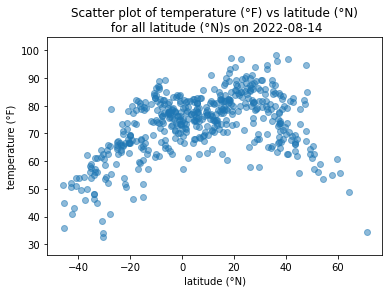

In [11]:
# Scatter plot of temperature vs latititude
scatter(weather_data, 'latitude (°N)', 'temperature (°F)', save=True)

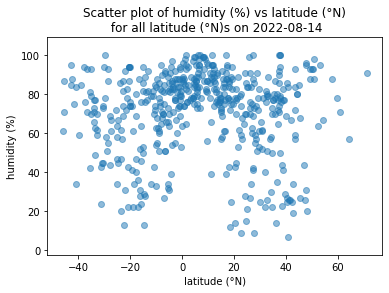

In [12]:
scatter(weather_data, 'latitude (°N)', 'humidity (%)', save=True)

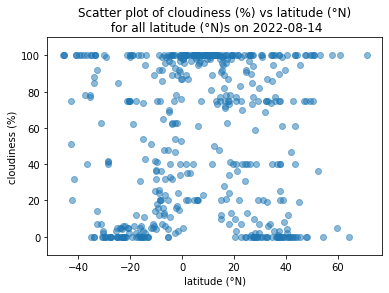

In [13]:
scatter(weather_data, 'latitude (°N)', 'cloudiness (%)', save=True)

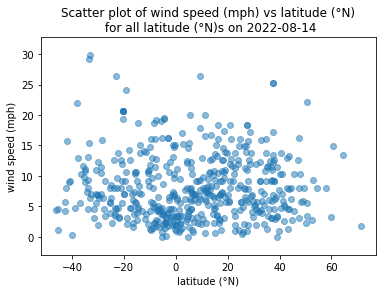

In [14]:
scatter(weather_data, 'latitude (°N)', 'wind speed (mph)', save=True)

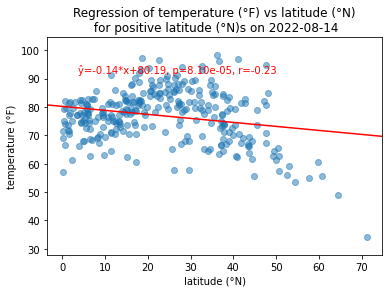

In [15]:
scatter(weather_data, 'latitude (°N)', 'temperature (°F)', regress=True, subset='positive', save=True)

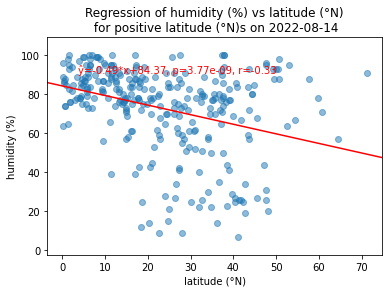

In [16]:
scatter(weather_data, 'latitude (°N)', 'humidity (%)', regress=True, subset='positive', save=True)

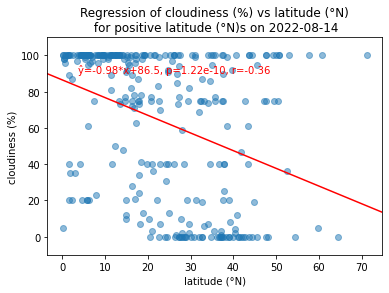

In [17]:
scatter(weather_data, 'latitude (°N)', 'cloudiness (%)', regress=True, subset='positive', save=True)

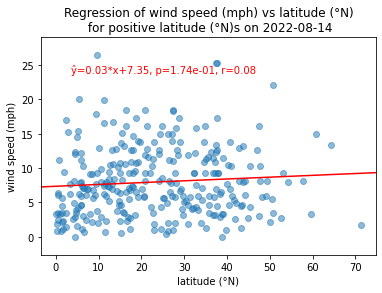

In [18]:
scatter(weather_data, 'latitude (°N)', 'wind speed (mph)', regress=True, subset='positive', save=True)

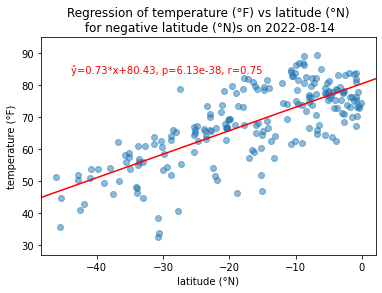

In [19]:
scatter(weather_data, 'latitude (°N)', 'temperature (°F)', regress=True, subset='negative', save=True)

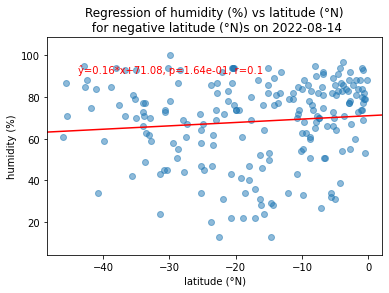

In [20]:
scatter(weather_data, 'latitude (°N)', 'humidity (%)', regress=True, subset='negative', save=True)

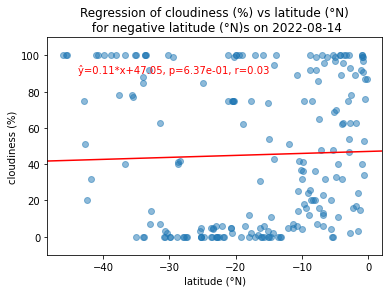

In [21]:
scatter(weather_data, 'latitude (°N)', 'cloudiness (%)', regress=True, subset='negative', save=True)

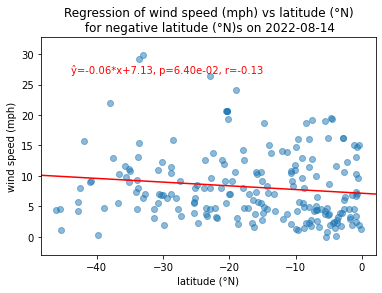

In [22]:
scatter(weather_data, 'latitude (°N)', 'wind speed (mph)', regress=True, subset='negative', save=True)